#### Tutorial para realizar o download da série temporal de Evapotranspiração de referência

In [1]:
import pandas as pd
import ee
import datetime 
import geemap

In [2]:
ee.Initialize(project='et-brasil')

import sys

sys.path.append(r'C:\\Users\\hge2022\\OneDrive\\doutorado\\reunioes_ted\\etr_era5')

### Importando as funções presentes no arquivo 'model'

In [3]:
import model

### Definir o período a ser analisado e obter uma coleção de etr utilizando as funções existentes em 'model'

##### O modelo retorna a ETr da grama (ETo24h) e a ETr da alfafa (ETr24h)

In [4]:
# Data inicial
start_date = '2019-01-01'

# Data final
end_date = '2020-01-01'

# Dados diários meteorológicos
meteo_daily = 'ECMWF/ERA5_LAND/DAILY_AGGR' \

# Dados de elevação
dem = ee.Image("CGIAR/SRTM90_V4")

# Criando uma lista de data
n_dif = ee.Date(end_date).difference(ee.Date(start_date),'day').round()
dates = ee.List.sequence(0,n_dif,1)
def make_datelist(n): return ee.Date(start_date).advance(n,'day')

# Lista de datas
dates = dates.map(make_datelist)

# Criando uma lista de etr
def get_etr(date):

    time_start = ee.Date(date)

    # Obtendo dados meteorologicos
    tmin, tmax, tair_k, wind_med, rh, rso24h =model.meteo_era5land(time_start, meteo_daily)

    # Obtendo Rn diário
    rad_24h = model.radiation_24h(date, tmax, tmin, dem, rso24h)

    # Obtendo ETr grama e da alfafa
    etr_image = model.etr(tmin, tmax, tair_k, wind_med, dem, rad_24h)

    return etr_image.set('system:time_start',time_start.millis())


etr_coll = ee.ImageCollection(dates.map(get_etr))

### Extraindo uma tabela

In [12]:
# Shapefile
shp_file = r'C:\\Users\\hge2022\\OneDrive\\doutorado\\reunioes_ted\\geometria\\geometria_exemplo.shp'

# Convertendo para objeto GEE (Feature Collection)
geom = geemap.shp_to_ee(shp_file)

# Função para transformar ImageCollection em uma tabela
def get_region_df(info):
    """Convert the output of getRegions to a pandas dataframe"""
    col_dict = {}
    info_dict = {}
    for i, k in enumerate(info[0][4:]):
        col_dict[k] = i+4
        info_dict[k] = {}
        
    for row in info[1:]:
        date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')
        for k, v in col_dict.items():
            info_dict[k][date] = row[col_dict[k]]
            
    return pd.DataFrame.from_dict(info_dict).sort_index()

# Tabela
df = get_region_df(etr_coll.getRegion(geom.geometry(), scale=10000).getInfo()).reset_index()
df['date'] = pd.to_datetime(df['index'])


C:\Users\hge2022\AppData\Local\Temp\ipykernel_83420\1186587214.py:17: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  date = datetime.datetime.utcfromtimestamp(row[3] / 1000.0).strftime('%Y-%m-%d')


In [9]:
df.head()

,index,eto24h,etr24h,date
0,2019-01-01,4.089367,4.298016,2019-01-01
1,2019-01-02,5.099789,5.356191,2019-01-02
2,2019-01-03,5.634180,5.967934,2019-01-03
3,2019-01-04,5.182792,5.491493,2019-01-04
4,2019-01-05,3.485984,3.772167,2019-01-05


### Visualizando a serie temporal no Matplotlib

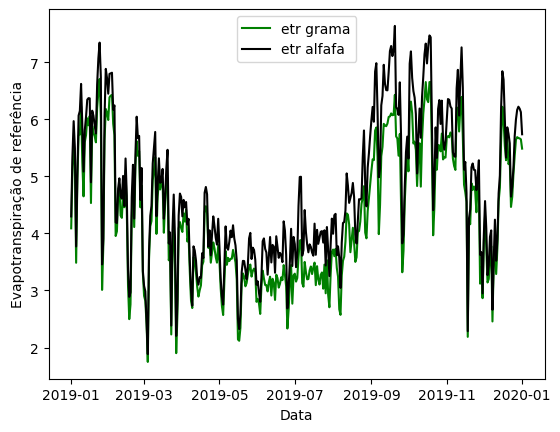

In [11]:
### Visualizando série de etr
import matplotlib.pyplot as plt


plt.plot(df['date'],df['eto24h'], color='green', label='etr grama')
plt.plot(df['date'],df['etr24h'], color='black', label='etr alfafa')

plt.ylabel("Evapotranspiração de referência")
plt.xlabel("Data")
plt.legend()